In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "sfbu.edu"
full_url = "https://www.sfbu.edu/"

In [4]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [5]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [6]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [7]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
response = requests.get("https://www.sfbu.edu/", headers=headers)
print(response.content)

b'\n<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="og: https://ogp.me/ns#" class="h-100">\n  <head>\n    <meta charset="utf-8" />\n<style>.fa-sr-only, .sr-only {\n        position: absolute;\n        width: 1px;\n        height: 1px;\n        padding: 0;\n        margin: -1px;\n        overflow: hidden;\n        clip: rect(0, 0, 0, 0);\n        white-space: nowrap;\n        border-width: 0;\n      }</style>\n<style>\n[data-kwall-theme=\'custom\']\n{\n--kwall-color-primary-1: #003e69 !important;\n--kwall-color-primary-1-rgb: 0, 62, 105 !important;\n--kwall-color-primary-1-hover: #00244F !important;\n--kwall-color-primary-1-active: #001843 !important;\n--kwall-color-primary-2: #002045 !important;\n--kwall-color-primary-2-rgb: 0, 32, 69 !important;\n--kwall-color-primary-2-hover: #00062B !important;\n--kwall-color-primary-2-active: #00001F !important;\n--kwall-color-primary-3: #5FAAF2 !important;\n--kwall-color-primary-3-rgb: 95, 170, 242 !important;\n--kwall-color-primary-3-hover: #4

In [8]:

import hashlib
from urllib.parse import urlparse
from collections import deque
import os
import requests
from bs4 import BeautifulSoup

def get_domain_hyperlinks(domain, url):
    try:
        response = requests.get(url)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, "lxml")
        links = set()
        
        # Find all anchor tags with href attributes
        for link in soup.find_all('a', href=True):
            href = link['href']
            
            # Process relative URLs and convert them to absolute
            if href.startswith('/'):
                href = f"https://{domain}{href}"
            
            # Add links that belong to the same domain
            if domain in href:
                links.add(href)
        
        return links
    except Exception as e:
        print(f"Error retrieving links from {url}: {e}")
        return set()  # Return an empty set in case of failure

def get_safe_filename(url):
    # Create a hash of the URL to use as a unique, short filename
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    return url_hash

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # For debugging and to see the progress

        try:
            # Use a safe filename based on the URL hash
            filename = get_safe_filename(url)

            # Save text from the url to a <url-hash>.txt file
            with open(f'text/{local_domain}/{filename}.txt', "w", encoding="utf-8") as f:
                # Get the text from the URL using BeautifulSoup
                response = requests.get(url)
                response.encoding = 'utf-8'

                # Check if the page is HTML
                if "text/html" in response.headers.get("Content-Type", ""):
                    soup = BeautifulSoup(response.text,"html.parser")

                    # Get the text but remove the tags
                    text = soup.get_text()

                    # Handle JavaScript-heavy pages
                    if "You need to enable JavaScript to run this app." in text:
                        print(f"Unable to parse page {url} due to JavaScript being required.")
                        continue

                    # Write the text to the file in the text directory
                    f.write(text)

                    # Get the hyperlinks from the URL and add them to the queue
                    for link in get_domain_hyperlinks(local_domain, url):
                        if link not in seen:
                            queue.append(link)
                            seen.add(link)
                else:
                    print(f"{url} is not an HTML page, skipping.")

        except requests.exceptions.RequestException as e:
            print(f"Failed to crawl {url}: {e}")

# Start crawling from the desired URL
crawl("https://www.sfbu.edu/")

https://www.sfbu.edu/
https://www.sfbu.edu/learning-teaching/graduate-programs
https://www.sfbu.edu/programs/master-business-administration-mba
https://www.sfbu.edu/programs/bachelor-science-business-administration
https://www.sfbu.edu/programs/master-science-computer-science-mscs
https://www.sfbu.edu/programs/bachelor-science-computer-science
https://www.sfbu.edu/programs/graduate-certificate-business-management
https://www.sfbu.edu/programs/aspiring-community-entrepreneurs-ace-certificate
https://www.sfbu.edu/programs/master-science-electrical-engineering-msee
https://www.sfbu.edu/programs/master-science-data-science-msds
https://www.sfbu.edu/programs/master-science-business-analytics-msba
https://www.sfbu.edu/financial-support/student-employment
https://www.sfbu.edu/financial-support/interactive-scholarship-tool
https://www.sfbu.edu/admissions/transfer
https://www.sfbu.edu/sites/default/files/Documents/sacramento-city-college.pdf
https://www.sfbu.edu/sites/default/files/Documents/sa

In [16]:
pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 1.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [10]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + "www."+ domain + "/"):

    # Open the file and read the text
    with open("text/" + "www."+ domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/r2/t4hb7m2d6lbgjlf7hq_0j_800000gn/T/ipykernel_18356/861962914.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,fname,text
0,d6c850d727d8691d2dbe4,d6c850d727d8691d2dbe4. Wellness Wednesda...
1,26b4b2129d9b0a43bf5d7,26b4b2129d9b0a43bf5d7. Page not found | S...
2,0a8ba55056f40eb98fe36,0a8ba55056f40eb98fe36. San Francisco Bay...
3,2bd924ea3c20efe2e7ccb,2bd924ea3c20efe2e7ccb. Counselor Luncheo...
4,966c321ffdfa2878334b5,966c321ffdfa2878334b5. Custom AI tools h...


In [12]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.0/907.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


<Axes: >

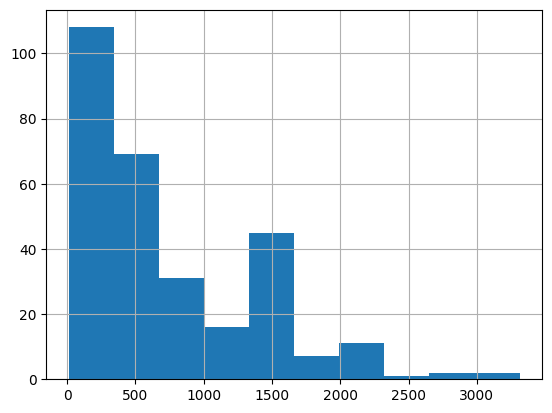

In [13]:

import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [14]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

In [16]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
Note: you may need to restart the kernel to use updated packages.


In [17]:
import openai
import pandas as pd

# Set your OpenAI API key
openai.api_key = ""

# Function to get embeddings for a text
def get_embedding(text):
    response = openai.embeddings.create(input=[text], model="text-embedding-ada-002")
    
    # Access the embedding from the response object correctly using dot notation
    return response.data[0].embedding

# Assuming df is a pandas DataFrame with a 'text' column
df = pd.DataFrame({'text': ["Sample text 1", "Sample text 2"]})  # Example DataFrame

# Apply the function to get embeddings
df['embeddings'] = df['text'].apply(get_embedding)

# Save the embeddings to a CSV file
df.to_csv('processed/embeddings.csv', index=False)

# Show the first few rows of the DataFrame
print(df.head())

            text                                         embeddings
0  Sample text 1  [-0.0012473410461097956, -0.00466702738776803,...
1  Sample text 2  [-0.01386114489287138, -0.009656688198447227, ...


<Axes: >

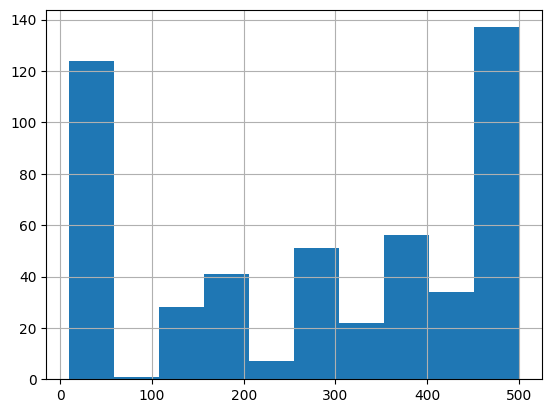

In [18]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [25]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 1.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [26]:

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the embeddings from the CSV file
df = pd.read_csv('processed/embeddings.csv', index_col=0)

# Convert the embeddings from strings back to arrays
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

# Define a function to calculate distances using cosine similarity
def calculate_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0]

# Example usage: comparing the similarity between the first two embeddings
similarity = calculate_similarity(df['embeddings'].iloc[0], df['embeddings'].iloc[1])

print(f"Cosine Similarity between the first two embeddings: {similarity}")

# Show the first few rows of the DataFrame
print(df.head())

Cosine Similarity between the first two embeddings: 0.9574294841238892
                                                      embeddings
text                                                            
Sample text 1  [-0.0012473410461097956, -0.00466702738776803,...
Sample text 2  [-0.01386114489287138, -0.009656688198447227, ...


In [27]:
# Example: Original text data
texts = ["Sample text 1", "Sample text 2", "Sample text 3"]

# Create embeddings for each text
embeddings = []
for text in texts:
    response = openai.embeddings.create(input=[text], model='text-embedding-ada-002')
    embeddings.append(response.data[0].embedding)

# Create a DataFrame that includes both the text and embeddings
df = pd.DataFrame({
    'text': texts,
    'embeddings': embeddings
})

# Save the DataFrame to CSV
df.to_csv('processed/embeddings_with_text.csv', index=False)

In [28]:
# Load the new CSV file that includes both 'text' and 'embeddings'
df = pd.read_csv('processed/embeddings_with_text.csv')

# Convert the embeddings back to NumPy arrays
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

print(df.head())  # Verify the text and embeddings are present

            text                                         embeddings
0  Sample text 1  [-0.0012473410461097956, -0.00466702738776803,...
1  Sample text 2  [-0.01386114489287138, -0.009656688198447227, ...
2  Sample text 3  [-0.010653824545443058, -0.006785593461245298,...


In [29]:
def create_context(question, df, max_len=1800):
    """
    Create a context for a question by finding the most similar context from the dataframe.
    """

    # Get the embeddings for the question
    response = openai.embeddings.create(input=[question], model='text-embedding-ada-002')
    q_embeddings = response.data[0].embedding

    # Calculate cosine similarities between the question embedding and document embeddings
    df['distances'] = df['embeddings'].apply(lambda x: cosine_similarity([q_embeddings], [x])[0][0])

    context = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=False).iterrows():
        cur_len += len(row['text'].split())  # Assuming 'text' column now exists
        if cur_len > max_len:
            break
        context.append(row["text"])

    # Return the concatenated context
    return "\n\n###\n\n".join(context)

In [36]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts.
    """
    context = create_context(question, df, max_len=max_len)

    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(e)
        return ""

In [37]:
answer_question(df, question="Where is the campus?")

"I'm sorry, but based on the provided context, there is no specific information about the campus location. Could you please provide more details or context so I can assist you better?"

In [38]:
answer_question(df, question="Wellness Wednesdays")

'Wellness Wednesdays are dedicated to promoting health and well-being among individuals. It is a day focused on activities, tips, and resources to help people improve their physical, mental, and emotional wellness. It can include activities such as exercise classes, mindfulness sessions, healthy eating tips, stress management techniques, and more. Wellness Wednesdays aim to encourage individuals to prioritize their health and make positive lifestyle choices.'